# Collect the historical stock price information

In [1]:
#Necessary imports

In [21]:
import os
import pickle
import quandl
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow.contrib import rnn
%matplotlib inline

In [3]:
#Some useful functions to fetch the data .

In [4]:
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')


def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)


def load_pickle(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)


def fetch_stock_price(symbol,
                      from_date,
                      to_date,
                      cache_path="./tmp/prices/"):
    assert(from_date <= to_date)

    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)

    try:
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)

    except IOError:
        historic = quandl.get("WIKI/" + symbol,
                              start_date=date_obj_to_str(from_date),
                              end_date=date_obj_to_str(to_date))

        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
        print("saved into", price_filepath)

    return prices

def format_dataset(values, temporal_features):
    feat_splits = [values[i:i + temporal_features] for i in range(len(values) - temporal_features)]
    feats = np.vstack(feat_splits)
    labels = np.array(values[temporal_features:])
    return feats, labels


def matrix_to_array(m):
    return np.asarray(m).reshape(-1)

In [5]:
#Let's print the adjusted price of the General Electronics stock price (whose symbol is GE) from 2015 to 2016:

In [7]:
print(fetch_stock_price("GE",
      datetime.date(2015, 1, 1),
      datetime.date(2016, 12, 31)))

saved into ./tmp/prices/GE_2015-01-01_2016-12-31.pk
[22.885078190233, 22.46500093694, 21.980998884234, 21.990130998436, 22.254962310294, 21.944470427426, 21.898809856416, 21.789224485992, 21.716167572376, 21.533525288335, 21.542657402537, 21.78009237179, 21.953602541628, 22.172773282476, 22.355415566516, 22.455868822738, 22.264094424496, 21.770960257588, 21.990130998436, 21.816620828598, 22.108848483062, 22.346283452314, 22.063187912052, 22.37367979492, 22.391944023324, 22.501529393748, 22.574586307364, 22.620246878374, 22.729832248799, 22.967267218051, 22.985531446455, 23.058588360071, 23.049456245869, 23.233778167067, 23.196913782828, 23.399667896146, 23.878904891262, 23.860472699142, 23.952633659741, 24.06322681246, 23.832824410962, 23.648502489764, 23.795960026723, 23.427316184326, 23.630070297644, 23.196913782828, 23.215345974947, 23.408883992206, 23.077104534049, 23.454964472505, 23.325939127667, 23.630070297644, 23.344371319786, 23.408883992206, 23.473396664625, 23.289074743427,

In [8]:
#Plot the GE Stock price from Jan 2015 to Dec 2016 to visualize better

loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk


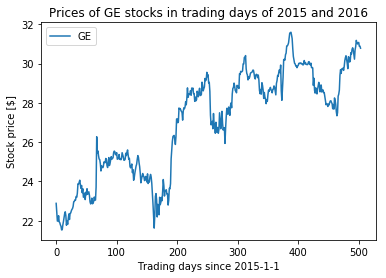

In [9]:
symbols = [ "GE"]
ax = plt.subplot(1,1,1)
for sym in symbols:
    prices = fetch_stock_price(
        sym, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
    ax.plot(range(len(prices)), prices, label=sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel("Trading days since 2015-1-1")
plt.ylabel("Stock price [$]")
plt.title("Prices of GE stocks in trading days of 2015 and 2016")
plt.show()

# Build a linear regression model as a benchmark model

In [10]:
# Have a evaluate function which can calculate the MSE and MAE metrics.

In [11]:
def evaluate_ts(features, y_true, y_pred):
    print("Evaluation of the predictions:")
    print("MSE:", np.mean(np.square(y_true - y_pred)))
    print("mae:", np.mean(np.abs(y_true - y_pred)))

    #print("Benchmark: if prediction == last feature")
    #print("MSE:", np.mean(np.square(features[:, -1] - y_true)))
    #print("mae:", np.mean(np.abs(features[:, -1] - y_true)))

    plt.plot(matrix_to_array(y_true), 'b')
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()

    error = np.abs(matrix_to_array(y_pred) - matrix_to_array(y_true))
    plt.plot(error, 'r')
    fit = np.polyfit(range(len(error)), error, deg=1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel("Days")
    plt.ylabel("Prediction error L1 norm")
    plt.title("Prediction error (absolute) and trendline")
    plt.show()

In [12]:
 #We have one year of training data (2015) which will be used to predict the stock price for the whole of 2016:

In [17]:
tf.reset_default_graph()
tf.set_random_seed(101)

symbol = "GE"
feat_dimension = 20
train_size = 252
test_size = 252 - feat_dimension

# Settings for tensorflow
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer
n_epochs = 10000

# Fetch the values, and prepare the train/test split
stock_values = fetch_stock_price(symbol, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
minibatch_cos_X, minibatch_cos_y = format_dataset(stock_values, feat_dimension)
train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)


# Here, the tensorflow code
X_tf = tf.placeholder("float", shape=(None, feat_dimension), name="X")
y_tf = tf.placeholder("float", shape=(None, 1), name="y")


# Here the model: a simple linear regressor
def regression_ANN(x, weights, biases):
    return tf.add(biases, tf.matmul(x, weights))


# Store layers weight & bias
weights = tf.Variable(tf.truncated_normal([feat_dimension, 1], mean=0.0, stddev=1.0), name="weights")
biases = tf.Variable(tf.zeros([1, 1]), name="bias")


# Model, cost and optimizer
y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)

loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk


In [19]:
#Train the linear regression benchmark model and evaluate using MSE and MAE metrics

Training iteration 0 MSE 4740.279
Training iteration 1 MSE 4671.165
Training iteration 2 MSE 4602.5723
Training iteration 3 MSE 4534.5117
Training iteration 4 MSE 4466.9897
Training iteration 5 MSE 4400.014
Training iteration 6 MSE 4333.594
Training iteration 7 MSE 4267.7363
Training iteration 8 MSE 4202.4497
Training iteration 9 MSE 4137.741
Training iteration 10 MSE 4073.6157
Training iteration 11 MSE 4010.082
Training iteration 12 MSE 3947.1448
Training iteration 13 MSE 3884.81
Training iteration 14 MSE 3823.084
Training iteration 15 MSE 3761.97
Training iteration 16 MSE 3701.474
Training iteration 17 MSE 3641.5996
Training iteration 18 MSE 3582.3508
Training iteration 19 MSE 3523.73
Training iteration 20 MSE 3465.741
Training iteration 21 MSE 3408.3867
Training iteration 22 MSE 3351.6685
Training iteration 23 MSE 3295.5884
Training iteration 24 MSE 3240.1497
Training iteration 25 MSE 3185.3508
Training iteration 26 MSE 3131.194
Training iteration 27 MSE 3077.6792
Training iteration

Training iteration 238 MSE 13.640464
Training iteration 239 MSE 13.293771
Training iteration 240 MSE 12.959468
Training iteration 241 MSE 12.63714
Training iteration 242 MSE 12.3264065
Training iteration 243 MSE 12.026901
Training iteration 244 MSE 11.738234
Training iteration 245 MSE 11.460059
Training iteration 246 MSE 11.192016
Training iteration 247 MSE 10.9337435
Training iteration 248 MSE 10.684955
Training iteration 249 MSE 10.445332
Training iteration 250 MSE 10.214555
Training iteration 251 MSE 9.992331
Training iteration 252 MSE 9.778368
Training iteration 253 MSE 9.5724
Training iteration 254 MSE 9.374124
Training iteration 255 MSE 9.183275
Training iteration 256 MSE 8.999618
Training iteration 257 MSE 8.822893
Training iteration 258 MSE 8.652887
Training iteration 259 MSE 8.489322
Training iteration 260 MSE 8.331997
Training iteration 261 MSE 8.180713
Training iteration 262 MSE 8.035214
Training iteration 263 MSE 7.8953333
Training iteration 264 MSE 7.7608514
Training itera

Training iteration 581 MSE 4.631224
Training iteration 582 MSE 4.631153
Training iteration 583 MSE 4.6310816
Training iteration 584 MSE 4.631012
Training iteration 585 MSE 4.6309414
Training iteration 586 MSE 4.630872
Training iteration 587 MSE 4.630801
Training iteration 588 MSE 4.6307297
Training iteration 589 MSE 4.6306596
Training iteration 590 MSE 4.630589
Training iteration 591 MSE 4.6305165
Training iteration 592 MSE 4.630446
Training iteration 593 MSE 4.6303773
Training iteration 594 MSE 4.630304
Training iteration 595 MSE 4.6302347
Training iteration 596 MSE 4.630165
Training iteration 597 MSE 4.630093
Training iteration 598 MSE 4.6300216
Training iteration 599 MSE 4.629949
Training iteration 600 MSE 4.6298785
Training iteration 601 MSE 4.6298056
Training iteration 602 MSE 4.629738
Training iteration 603 MSE 4.629664
Training iteration 604 MSE 4.6295943
Training iteration 605 MSE 4.629521
Training iteration 606 MSE 4.6294484
Training iteration 607 MSE 4.6293755
Training iterat

Training iteration 956 MSE 4.5995092
Training iteration 957 MSE 4.5994105
Training iteration 958 MSE 4.5993094
Training iteration 959 MSE 4.599211
Training iteration 960 MSE 4.5991125
Training iteration 961 MSE 4.599014
Training iteration 962 MSE 4.5989146
Training iteration 963 MSE 4.598813
Training iteration 964 MSE 4.5987163
Training iteration 965 MSE 4.598613
Training iteration 966 MSE 4.5985146
Training iteration 967 MSE 4.598415
Training iteration 968 MSE 4.5983143
Training iteration 969 MSE 4.5982137
Training iteration 970 MSE 4.5981154
Training iteration 971 MSE 4.598013
Training iteration 972 MSE 4.597915
Training iteration 973 MSE 4.597814
Training iteration 974 MSE 4.5977144
Training iteration 975 MSE 4.597615
Training iteration 976 MSE 4.5975103
Training iteration 977 MSE 4.5974107
Training iteration 978 MSE 4.5973115
Training iteration 979 MSE 4.5972104
Training iteration 980 MSE 4.5971074
Training iteration 981 MSE 4.597012
Training iteration 982 MSE 4.596905
Training ite

Training iteration 1251 MSE 4.5668445
Training iteration 1252 MSE 4.5667205
Training iteration 1253 MSE 4.5665994
Training iteration 1254 MSE 4.566475
Training iteration 1255 MSE 4.5663548
Training iteration 1256 MSE 4.5662303
Training iteration 1257 MSE 4.566108
Training iteration 1258 MSE 4.5659814
Training iteration 1259 MSE 4.565861
Training iteration 1260 MSE 4.5657372
Training iteration 1261 MSE 4.5656137
Training iteration 1262 MSE 4.56549
Training iteration 1263 MSE 4.565366
Training iteration 1264 MSE 4.565243
Training iteration 1265 MSE 4.5651226
Training iteration 1266 MSE 4.5649943
Training iteration 1267 MSE 4.5648713
Training iteration 1268 MSE 4.5647492
Training iteration 1269 MSE 4.5646234
Training iteration 1270 MSE 4.5645013
Training iteration 1271 MSE 4.5643754
Training iteration 1272 MSE 4.564251
Training iteration 1273 MSE 4.564125
Training iteration 1274 MSE 4.5640016
Training iteration 1275 MSE 4.563877
Training iteration 1276 MSE 4.5637527
Training iteration 127

Training iteration 1581 MSE 4.5218115
Training iteration 1582 MSE 4.5216613
Training iteration 1583 MSE 4.5215096
Training iteration 1584 MSE 4.5213594
Training iteration 1585 MSE 4.5212092
Training iteration 1586 MSE 4.521057
Training iteration 1587 MSE 4.520905
Training iteration 1588 MSE 4.5207553
Training iteration 1589 MSE 4.520602
Training iteration 1590 MSE 4.5204515
Training iteration 1591 MSE 4.520301
Training iteration 1592 MSE 4.5201497
Training iteration 1593 MSE 4.5199957
Training iteration 1594 MSE 4.519846
Training iteration 1595 MSE 4.519693
Training iteration 1596 MSE 4.5195394
Training iteration 1597 MSE 4.5193887
Training iteration 1598 MSE 4.5192385
Training iteration 1599 MSE 4.5190835
Training iteration 1600 MSE 4.5189342
Training iteration 1601 MSE 4.5187826
Training iteration 1602 MSE 4.518628
Training iteration 1603 MSE 4.518477
Training iteration 1604 MSE 4.5183215
Training iteration 1605 MSE 4.5181704
Training iteration 1606 MSE 4.5180154
Training iteration 1

Training iteration 1912 MSE 4.4669046
Training iteration 1913 MSE 4.4667234
Training iteration 1914 MSE 4.4665413
Training iteration 1915 MSE 4.46636
Training iteration 1916 MSE 4.466176
Training iteration 1917 MSE 4.465997
Training iteration 1918 MSE 4.4658127
Training iteration 1919 MSE 4.4656296
Training iteration 1920 MSE 4.4654503
Training iteration 1921 MSE 4.4652667
Training iteration 1922 MSE 4.4650855
Training iteration 1923 MSE 4.4649024
Training iteration 1924 MSE 4.4647193
Training iteration 1925 MSE 4.4645343
Training iteration 1926 MSE 4.4643536
Training iteration 1927 MSE 4.464172
Training iteration 1928 MSE 4.46399
Training iteration 1929 MSE 4.463808
Training iteration 1930 MSE 4.463623
Training iteration 1931 MSE 4.463437
Training iteration 1932 MSE 4.463253
Training iteration 1933 MSE 4.46307
Training iteration 1934 MSE 4.462888
Training iteration 1935 MSE 4.4627047
Training iteration 1936 MSE 4.46252
Training iteration 1937 MSE 4.462336
Training iteration 1938 MSE 4

Training iteration 2205 MSE 4.409398
Training iteration 2206 MSE 4.4091854
Training iteration 2207 MSE 4.408973
Training iteration 2208 MSE 4.408763
Training iteration 2209 MSE 4.4085507
Training iteration 2210 MSE 4.408339
Training iteration 2211 MSE 4.408128
Training iteration 2212 MSE 4.407914
Training iteration 2213 MSE 4.4077024
Training iteration 2214 MSE 4.407489
Training iteration 2215 MSE 4.407279
Training iteration 2216 MSE 4.407066
Training iteration 2217 MSE 4.406851
Training iteration 2218 MSE 4.4066415
Training iteration 2219 MSE 4.4064264
Training iteration 2220 MSE 4.406214
Training iteration 2221 MSE 4.405999
Training iteration 2222 MSE 4.4057884
Training iteration 2223 MSE 4.405574
Training iteration 2224 MSE 4.405359
Training iteration 2225 MSE 4.4051456
Training iteration 2226 MSE 4.4049335
Training iteration 2227 MSE 4.404717
Training iteration 2228 MSE 4.4045033
Training iteration 2229 MSE 4.4042916
Training iteration 2230 MSE 4.4040775
Training iteration 2231 MSE

Training iteration 2516 MSE 4.3383145
Training iteration 2517 MSE 4.3380666
Training iteration 2518 MSE 4.337821
Training iteration 2519 MSE 4.337576
Training iteration 2520 MSE 4.3373303
Training iteration 2521 MSE 4.3370814
Training iteration 2522 MSE 4.336834
Training iteration 2523 MSE 4.3365855
Training iteration 2524 MSE 4.3363414
Training iteration 2525 MSE 4.336092
Training iteration 2526 MSE 4.3358445
Training iteration 2527 MSE 4.3356
Training iteration 2528 MSE 4.3353505
Training iteration 2529 MSE 4.3351045
Training iteration 2530 MSE 4.3348536
Training iteration 2531 MSE 4.3346086
Training iteration 2532 MSE 4.334358
Training iteration 2533 MSE 4.33411
Training iteration 2534 MSE 4.3338623
Training iteration 2535 MSE 4.3336134
Training iteration 2536 MSE 4.3333673
Training iteration 2537 MSE 4.33312
Training iteration 2538 MSE 4.332868
Training iteration 2539 MSE 4.332621
Training iteration 2540 MSE 4.332372
Training iteration 2541 MSE 4.3321204
Training iteration 2542 MSE

Training iteration 2864 MSE 4.2452955
Training iteration 2865 MSE 4.245004
Training iteration 2866 MSE 4.244716
Training iteration 2867 MSE 4.244427
Training iteration 2868 MSE 4.2441373
Training iteration 2869 MSE 4.243848
Training iteration 2870 MSE 4.243556
Training iteration 2871 MSE 4.243267
Training iteration 2872 MSE 4.2429776
Training iteration 2873 MSE 4.242687
Training iteration 2874 MSE 4.2423973
Training iteration 2875 MSE 4.242107
Training iteration 2876 MSE 4.2418175
Training iteration 2877 MSE 4.241524
Training iteration 2878 MSE 4.2412343
Training iteration 2879 MSE 4.2409444
Training iteration 2880 MSE 4.240653
Training iteration 2881 MSE 4.2403607
Training iteration 2882 MSE 4.24007
Training iteration 2883 MSE 4.2397785
Training iteration 2884 MSE 4.2394876
Training iteration 2885 MSE 4.239197
Training iteration 2886 MSE 4.2389026
Training iteration 2887 MSE 4.238611
Training iteration 2888 MSE 4.2383194
Training iteration 2889 MSE 4.2380276
Training iteration 2890 MS

Training iteration 3204 MSE 4.139283
Training iteration 3205 MSE 4.1389465
Training iteration 3206 MSE 4.138613
Training iteration 3207 MSE 4.138276
Training iteration 3208 MSE 4.1379423
Training iteration 3209 MSE 4.137604
Training iteration 3210 MSE 4.137269
Training iteration 3211 MSE 4.1369348
Training iteration 3212 MSE 4.136598
Training iteration 3213 MSE 4.13626
Training iteration 3214 MSE 4.1359234
Training iteration 3215 MSE 4.1355867
Training iteration 3216 MSE 4.135251
Training iteration 3217 MSE 4.134915
Training iteration 3218 MSE 4.134576
Training iteration 3219 MSE 4.134239
Training iteration 3220 MSE 4.1339016
Training iteration 3221 MSE 4.133566
Training iteration 3222 MSE 4.133226
Training iteration 3223 MSE 4.132888
Training iteration 3224 MSE 4.132551
Training iteration 3225 MSE 4.132211
Training iteration 3226 MSE 4.1318727
Training iteration 3227 MSE 4.131537
Training iteration 3228 MSE 4.131197
Training iteration 3229 MSE 4.130858
Training iteration 3230 MSE 4.13

Training iteration 3563 MSE 4.0095572
Training iteration 3564 MSE 4.009172
Training iteration 3565 MSE 4.0087843
Training iteration 3566 MSE 4.0083942
Training iteration 3567 MSE 4.008006
Training iteration 3568 MSE 4.007616
Training iteration 3569 MSE 4.0072284
Training iteration 3570 MSE 4.006839
Training iteration 3571 MSE 4.0064507
Training iteration 3572 MSE 4.0060587
Training iteration 3573 MSE 4.005669
Training iteration 3574 MSE 4.0052814
Training iteration 3575 MSE 4.004889
Training iteration 3576 MSE 4.0045004
Training iteration 3577 MSE 4.0041094
Training iteration 3578 MSE 4.0037193
Training iteration 3579 MSE 4.0033293
Training iteration 3580 MSE 4.0029387
Training iteration 3581 MSE 4.002546
Training iteration 3582 MSE 4.002156
Training iteration 3583 MSE 4.001765
Training iteration 3584 MSE 4.0013733
Training iteration 3585 MSE 4.000981
Training iteration 3586 MSE 4.0005918
Training iteration 3587 MSE 4.0001993
Training iteration 3588 MSE 3.9998057
Training iteration 358

Training iteration 3900 MSE 3.8698092
Training iteration 3901 MSE 3.8693714
Training iteration 3902 MSE 3.8689277
Training iteration 3903 MSE 3.8684862
Training iteration 3904 MSE 3.8680415
Training iteration 3905 MSE 3.8676004
Training iteration 3906 MSE 3.867157
Training iteration 3907 MSE 3.8667164
Training iteration 3908 MSE 3.866272
Training iteration 3909 MSE 3.8658288
Training iteration 3910 MSE 3.8653865
Training iteration 3911 MSE 3.8649423
Training iteration 3912 MSE 3.8645
Training iteration 3913 MSE 3.8640537
Training iteration 3914 MSE 3.863613
Training iteration 3915 MSE 3.8631659
Training iteration 3916 MSE 3.8627234
Training iteration 3917 MSE 3.862279
Training iteration 3918 MSE 3.8618367
Training iteration 3919 MSE 3.861391
Training iteration 3920 MSE 3.860944
Training iteration 3921 MSE 3.860501
Training iteration 3922 MSE 3.8600545
Training iteration 3923 MSE 3.859608
Training iteration 3924 MSE 3.8591628
Training iteration 3925 MSE 3.858719
Training iteration 3926 

Training iteration 4278 MSE 3.6910272
Training iteration 4279 MSE 3.6905212
Training iteration 4280 MSE 3.690018
Training iteration 4281 MSE 3.6895127
Training iteration 4282 MSE 3.6890063
Training iteration 4283 MSE 3.688503
Training iteration 4284 MSE 3.6879969
Training iteration 4285 MSE 3.6874897
Training iteration 4286 MSE 3.6869836
Training iteration 4287 MSE 3.6864789
Training iteration 4288 MSE 3.6859713
Training iteration 4289 MSE 3.6854658
Training iteration 4290 MSE 3.684959
Training iteration 4291 MSE 3.6844506
Training iteration 4292 MSE 3.6839452
Training iteration 4293 MSE 3.6834402
Training iteration 4294 MSE 3.6829295
Training iteration 4295 MSE 3.6824248
Training iteration 4296 MSE 3.681916
Training iteration 4297 MSE 3.6814075
Training iteration 4298 MSE 3.6808984
Training iteration 4299 MSE 3.6803913
Training iteration 4300 MSE 3.6798844
Training iteration 4301 MSE 3.679375
Training iteration 4302 MSE 3.6788676
Training iteration 4303 MSE 3.678358
Training iteration

Training iteration 4641 MSE 3.4966106
Training iteration 4642 MSE 3.4960432
Training iteration 4643 MSE 3.4954762
Training iteration 4644 MSE 3.49491
Training iteration 4645 MSE 3.4943423
Training iteration 4646 MSE 3.4937747
Training iteration 4647 MSE 3.4932084
Training iteration 4648 MSE 3.4926422
Training iteration 4649 MSE 3.4920726
Training iteration 4650 MSE 3.4915059
Training iteration 4651 MSE 3.4909377
Training iteration 4652 MSE 3.4903684
Training iteration 4653 MSE 3.489799
Training iteration 4654 MSE 3.4892318
Training iteration 4655 MSE 3.4886618
Training iteration 4656 MSE 3.4880924
Training iteration 4657 MSE 3.4875233
Training iteration 4658 MSE 3.4869568
Training iteration 4659 MSE 3.4863856
Training iteration 4660 MSE 3.4858172
Training iteration 4661 MSE 3.4852457
Training iteration 4662 MSE 3.4846778
Training iteration 4663 MSE 3.4841084
Training iteration 4664 MSE 3.4835365
Training iteration 4665 MSE 3.4829676
Training iteration 4666 MSE 3.4823966
Training iterat

Training iteration 5033 MSE 3.2616951
Training iteration 5034 MSE 3.2610629
Training iteration 5035 MSE 3.260432
Training iteration 5036 MSE 3.2597997
Training iteration 5037 MSE 3.2591686
Training iteration 5038 MSE 3.2585366
Training iteration 5039 MSE 3.257906
Training iteration 5040 MSE 3.257272
Training iteration 5041 MSE 3.2566369
Training iteration 5042 MSE 3.256006
Training iteration 5043 MSE 3.255373
Training iteration 5044 MSE 3.2547388
Training iteration 5045 MSE 3.254107
Training iteration 5046 MSE 3.2534728
Training iteration 5047 MSE 3.2528386
Training iteration 5048 MSE 3.2522063
Training iteration 5049 MSE 3.2515728
Training iteration 5050 MSE 3.250937
Training iteration 5051 MSE 3.2503052
Training iteration 5052 MSE 3.2496684
Training iteration 5053 MSE 3.249036
Training iteration 5054 MSE 3.2484002
Training iteration 5055 MSE 3.2477648
Training iteration 5056 MSE 3.2471292
Training iteration 5057 MSE 3.246495
Training iteration 5058 MSE 3.245859
Training iteration 505

Training iteration 5422 MSE 3.0044599
Training iteration 5423 MSE 3.0037687
Training iteration 5424 MSE 3.0030816
Training iteration 5425 MSE 3.002391
Training iteration 5426 MSE 3.0017004
Training iteration 5427 MSE 3.0010095
Training iteration 5428 MSE 3.0003197
Training iteration 5429 MSE 2.9996305
Training iteration 5430 MSE 2.998938
Training iteration 5431 MSE 2.998247
Training iteration 5432 MSE 2.9975564
Training iteration 5433 MSE 2.996867
Training iteration 5434 MSE 2.9961753
Training iteration 5435 MSE 2.9954822
Training iteration 5436 MSE 2.994792
Training iteration 5437 MSE 2.9940996
Training iteration 5438 MSE 2.9934075
Training iteration 5439 MSE 2.9927168
Training iteration 5440 MSE 2.992025
Training iteration 5441 MSE 2.9913325
Training iteration 5442 MSE 2.9906406
Training iteration 5443 MSE 2.989948
Training iteration 5444 MSE 2.9892545
Training iteration 5445 MSE 2.988562
Training iteration 5446 MSE 2.9878702
Training iteration 5447 MSE 2.9871767
Training iteration 5

Training iteration 5785 MSE 2.7458107
Training iteration 5786 MSE 2.7450786
Training iteration 5787 MSE 2.744345
Training iteration 5788 MSE 2.743612
Training iteration 5789 MSE 2.7428763
Training iteration 5790 MSE 2.7421455
Training iteration 5791 MSE 2.74141
Training iteration 5792 MSE 2.7406776
Training iteration 5793 MSE 2.7399414
Training iteration 5794 MSE 2.7392077
Training iteration 5795 MSE 2.7384746
Training iteration 5796 MSE 2.737739
Training iteration 5797 MSE 2.7370045
Training iteration 5798 MSE 2.7362711
Training iteration 5799 MSE 2.735536
Training iteration 5800 MSE 2.7348018
Training iteration 5801 MSE 2.7340672
Training iteration 5802 MSE 2.7333329
Training iteration 5803 MSE 2.732596
Training iteration 5804 MSE 2.7318625
Training iteration 5805 MSE 2.731125
Training iteration 5806 MSE 2.730391
Training iteration 5807 MSE 2.7296546
Training iteration 5808 MSE 2.7289205
Training iteration 5809 MSE 2.7281857
Training iteration 5810 MSE 2.7274482
Training iteration 58

Training iteration 6152 MSE 2.4709723
Training iteration 6153 MSE 2.470212
Training iteration 6154 MSE 2.4694505
Training iteration 6155 MSE 2.4686882
Training iteration 6156 MSE 2.467927
Training iteration 6157 MSE 2.4671657
Training iteration 6158 MSE 2.4664032
Training iteration 6159 MSE 2.4656413
Training iteration 6160 MSE 2.4648798
Training iteration 6161 MSE 2.464118
Training iteration 6162 MSE 2.4633567
Training iteration 6163 MSE 2.462595
Training iteration 6164 MSE 2.4618313
Training iteration 6165 MSE 2.4610703
Training iteration 6166 MSE 2.460308
Training iteration 6167 MSE 2.4595468
Training iteration 6168 MSE 2.458785
Training iteration 6169 MSE 2.458022
Training iteration 6170 MSE 2.4572604
Training iteration 6171 MSE 2.4564989
Training iteration 6172 MSE 2.455736
Training iteration 6173 MSE 2.4549744
Training iteration 6174 MSE 2.454211
Training iteration 6175 MSE 2.4534483
Training iteration 6176 MSE 2.4526868
Training iteration 6177 MSE 2.4519243
Training iteration 61

Training iteration 6551 MSE 2.1650681
Training iteration 6552 MSE 2.1643014
Training iteration 6553 MSE 2.1635344
Training iteration 6554 MSE 2.1627676
Training iteration 6555 MSE 2.162001
Training iteration 6556 MSE 2.161233
Training iteration 6557 MSE 2.160466
Training iteration 6558 MSE 2.1596985
Training iteration 6559 MSE 2.1589315
Training iteration 6560 MSE 2.1581633
Training iteration 6561 MSE 2.1573975
Training iteration 6562 MSE 2.1566308
Training iteration 6563 MSE 2.1558638
Training iteration 6564 MSE 2.155096
Training iteration 6565 MSE 2.1543298
Training iteration 6566 MSE 2.1535618
Training iteration 6567 MSE 2.1527963
Training iteration 6568 MSE 2.1520298
Training iteration 6569 MSE 2.1512625
Training iteration 6570 MSE 2.150496
Training iteration 6571 MSE 2.149728
Training iteration 6572 MSE 2.148961
Training iteration 6573 MSE 2.1481948
Training iteration 6574 MSE 2.1474278
Training iteration 6575 MSE 2.1466625
Training iteration 6576 MSE 2.145896
Training iteration 6

Training iteration 6885 MSE 1.911344
Training iteration 6886 MSE 1.910596
Training iteration 6887 MSE 1.9098476
Training iteration 6888 MSE 1.9091
Training iteration 6889 MSE 1.9083503
Training iteration 6890 MSE 1.9076029
Training iteration 6891 MSE 1.906856
Training iteration 6892 MSE 1.906108
Training iteration 6893 MSE 1.9053601
Training iteration 6894 MSE 1.9046134
Training iteration 6895 MSE 1.9038665
Training iteration 6896 MSE 1.9031188
Training iteration 6897 MSE 1.9023722
Training iteration 6898 MSE 1.9016248
Training iteration 6899 MSE 1.9008775
Training iteration 6900 MSE 1.9001313
Training iteration 6901 MSE 1.8993841
Training iteration 6902 MSE 1.8986378
Training iteration 6903 MSE 1.8978914
Training iteration 6904 MSE 1.8971444
Training iteration 6905 MSE 1.8963978
Training iteration 6906 MSE 1.8956524
Training iteration 6907 MSE 1.894906
Training iteration 6908 MSE 1.8941587
Training iteration 6909 MSE 1.8934134
Training iteration 6910 MSE 1.8926678
Training iteration 6

Training iteration 7239 MSE 1.65381
Training iteration 7240 MSE 1.653108
Training iteration 7241 MSE 1.6524051
Training iteration 7242 MSE 1.6517041
Training iteration 7243 MSE 1.6510018
Training iteration 7244 MSE 1.6503003
Training iteration 7245 MSE 1.6495996
Training iteration 7246 MSE 1.6488972
Training iteration 7247 MSE 1.6481965
Training iteration 7248 MSE 1.647495
Training iteration 7249 MSE 1.6467961
Training iteration 7250 MSE 1.6460952
Training iteration 7251 MSE 1.6453947
Training iteration 7252 MSE 1.644693
Training iteration 7253 MSE 1.643994
Training iteration 7254 MSE 1.6432942
Training iteration 7255 MSE 1.6425934
Training iteration 7256 MSE 1.641894
Training iteration 7257 MSE 1.6411948
Training iteration 7258 MSE 1.6404957
Training iteration 7259 MSE 1.639797
Training iteration 7260 MSE 1.639098
Training iteration 7261 MSE 1.6383992
Training iteration 7262 MSE 1.6377008
Training iteration 7263 MSE 1.6370021
Training iteration 7264 MSE 1.6363043
Training iteration 72

Training iteration 7564 MSE 1.4355026
Training iteration 7565 MSE 1.4348657
Training iteration 7566 MSE 1.4342283
Training iteration 7567 MSE 1.4335915
Training iteration 7568 MSE 1.4329544
Training iteration 7569 MSE 1.4323175
Training iteration 7570 MSE 1.431681
Training iteration 7571 MSE 1.4310442
Training iteration 7572 MSE 1.4304096
Training iteration 7573 MSE 1.4297726
Training iteration 7574 MSE 1.429137
Training iteration 7575 MSE 1.4285023
Training iteration 7576 MSE 1.4278673
Training iteration 7577 MSE 1.4272318
Training iteration 7578 MSE 1.4265971
Training iteration 7579 MSE 1.4259629
Training iteration 7580 MSE 1.4253285
Training iteration 7581 MSE 1.4246953
Training iteration 7582 MSE 1.4240612
Training iteration 7583 MSE 1.4234272
Training iteration 7584 MSE 1.4227948
Training iteration 7585 MSE 1.4221612
Training iteration 7586 MSE 1.4215281
Training iteration 7587 MSE 1.4208955
Training iteration 7588 MSE 1.4202635
Training iteration 7589 MSE 1.4196317
Training itera

Training iteration 7951 MSE 1.2072824
Training iteration 7952 MSE 1.2067436
Training iteration 7953 MSE 1.206206
Training iteration 7954 MSE 1.2056676
Training iteration 7955 MSE 1.2051315
Training iteration 7956 MSE 1.2045939
Training iteration 7957 MSE 1.2040572
Training iteration 7958 MSE 1.203521
Training iteration 7959 MSE 1.2029849
Training iteration 7960 MSE 1.2024484
Training iteration 7961 MSE 1.2019125
Training iteration 7962 MSE 1.2013768
Training iteration 7963 MSE 1.2008419
Training iteration 7964 MSE 1.2003082
Training iteration 7965 MSE 1.1997728
Training iteration 7966 MSE 1.1992387
Training iteration 7967 MSE 1.1987045
Training iteration 7968 MSE 1.1981707
Training iteration 7969 MSE 1.1976373
Training iteration 7970 MSE 1.197104
Training iteration 7971 MSE 1.1965708
Training iteration 7972 MSE 1.1960384
Training iteration 7973 MSE 1.1955061
Training iteration 7974 MSE 1.1949745
Training iteration 7975 MSE 1.194442
Training iteration 7976 MSE 1.1939108
Training iterati

Training iteration 8176 MSE 1.0933932
Training iteration 8177 MSE 1.0929197
Training iteration 8178 MSE 1.0924469
Training iteration 8179 MSE 1.0919739
Training iteration 8180 MSE 1.091501
Training iteration 8181 MSE 1.0910295
Training iteration 8182 MSE 1.090558
Training iteration 8183 MSE 1.0900849
Training iteration 8184 MSE 1.0896144
Training iteration 8185 MSE 1.0891433
Training iteration 8186 MSE 1.0886724
Training iteration 8187 MSE 1.0882022
Training iteration 8188 MSE 1.0877324
Training iteration 8189 MSE 1.0872624
Training iteration 8190 MSE 1.0867926
Training iteration 8191 MSE 1.0863236
Training iteration 8192 MSE 1.0858544
Training iteration 8193 MSE 1.0853859
Training iteration 8194 MSE 1.0849181
Training iteration 8195 MSE 1.0844498
Training iteration 8196 MSE 1.0839818
Training iteration 8197 MSE 1.0835142
Training iteration 8198 MSE 1.0830464
Training iteration 8199 MSE 1.0825793
Training iteration 8200 MSE 1.082114
Training iteration 8201 MSE 1.0816475
Training iterat

Training iteration 8529 MSE 0.9446383
Training iteration 8530 MSE 0.94426817
Training iteration 8531 MSE 0.9438987
Training iteration 8532 MSE 0.9435303
Training iteration 8533 MSE 0.94316244
Training iteration 8534 MSE 0.94279325
Training iteration 8535 MSE 0.94242555
Training iteration 8536 MSE 0.94205797
Training iteration 8537 MSE 0.9416901
Training iteration 8538 MSE 0.94132274
Training iteration 8539 MSE 0.94095546
Training iteration 8540 MSE 0.9405891
Training iteration 8541 MSE 0.9402234
Training iteration 8542 MSE 0.93985695
Training iteration 8543 MSE 0.9394913
Training iteration 8544 MSE 0.93912536
Training iteration 8545 MSE 0.93876094
Training iteration 8546 MSE 0.9383957
Training iteration 8547 MSE 0.93803084
Training iteration 8548 MSE 0.9376664
Training iteration 8549 MSE 0.93730277
Training iteration 8550 MSE 0.9369397
Training iteration 8551 MSE 0.9365752
Training iteration 8552 MSE 0.9362121
Training iteration 8553 MSE 0.9358498
Training iteration 8554 MSE 0.93548656

Training iteration 8915 MSE 0.822582
Training iteration 8916 MSE 0.8223165
Training iteration 8917 MSE 0.8220508
Training iteration 8918 MSE 0.8217872
Training iteration 8919 MSE 0.8215218
Training iteration 8920 MSE 0.82125723
Training iteration 8921 MSE 0.82099277
Training iteration 8922 MSE 0.8207297
Training iteration 8923 MSE 0.8204646
Training iteration 8924 MSE 0.82020223
Training iteration 8925 MSE 0.8199395
Training iteration 8926 MSE 0.8196759
Training iteration 8927 MSE 0.8194136
Training iteration 8928 MSE 0.81915057
Training iteration 8929 MSE 0.818889
Training iteration 8930 MSE 0.81862605
Training iteration 8931 MSE 0.8183646
Training iteration 8932 MSE 0.8181042
Training iteration 8933 MSE 0.81784207
Training iteration 8934 MSE 0.81758136
Training iteration 8935 MSE 0.8173204
Training iteration 8936 MSE 0.81705993
Training iteration 8937 MSE 0.8167995
Training iteration 8938 MSE 0.8165392
Training iteration 8939 MSE 0.81627965
Training iteration 8940 MSE 0.8160203
Train

Training iteration 9262 MSE 0.74407333
Training iteration 9263 MSE 0.7438836
Training iteration 9264 MSE 0.74369293
Training iteration 9265 MSE 0.7435036
Training iteration 9266 MSE 0.7433134
Training iteration 9267 MSE 0.74312395
Training iteration 9268 MSE 0.7429341
Training iteration 9269 MSE 0.74274486
Training iteration 9270 MSE 0.7425549
Training iteration 9271 MSE 0.74236673
Training iteration 9272 MSE 0.742178
Training iteration 9273 MSE 0.7419895
Training iteration 9274 MSE 0.74180126
Training iteration 9275 MSE 0.7416128
Training iteration 9276 MSE 0.7414256
Training iteration 9277 MSE 0.74123716
Training iteration 9278 MSE 0.7410494
Training iteration 9279 MSE 0.7408623
Training iteration 9280 MSE 0.7406741
Training iteration 9281 MSE 0.7404877
Training iteration 9282 MSE 0.74030054
Training iteration 9283 MSE 0.740114
Training iteration 9284 MSE 0.7399275
Training iteration 9285 MSE 0.73974097
Training iteration 9286 MSE 0.73955536
Training iteration 9287 MSE 0.7393689
Trai

Training iteration 9665 MSE 0.68026406
Training iteration 9666 MSE 0.6801322
Training iteration 9667 MSE 0.6800011
Training iteration 9668 MSE 0.6798701
Training iteration 9669 MSE 0.6797387
Training iteration 9670 MSE 0.67960894
Training iteration 9671 MSE 0.6794777
Training iteration 9672 MSE 0.67934674
Training iteration 9673 MSE 0.6792168
Training iteration 9674 MSE 0.6790864
Training iteration 9675 MSE 0.6789562
Training iteration 9676 MSE 0.6788258
Training iteration 9677 MSE 0.678696
Training iteration 9678 MSE 0.678566
Training iteration 9679 MSE 0.67843634
Training iteration 9680 MSE 0.67830634
Training iteration 9681 MSE 0.678177
Training iteration 9682 MSE 0.6780479
Training iteration 9683 MSE 0.6779181
Training iteration 9684 MSE 0.67778826
Training iteration 9685 MSE 0.67765933
Training iteration 9686 MSE 0.6775314
Training iteration 9687 MSE 0.6774016
Training iteration 9688 MSE 0.67727286
Training iteration 9689 MSE 0.6771442
Training iteration 9690 MSE 0.6770156
Trainin

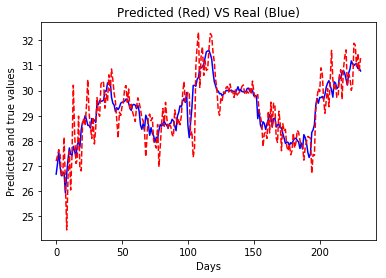

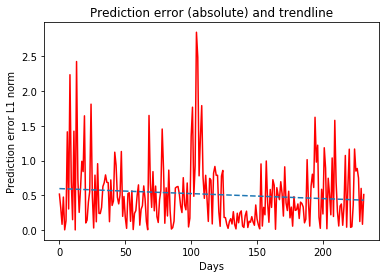

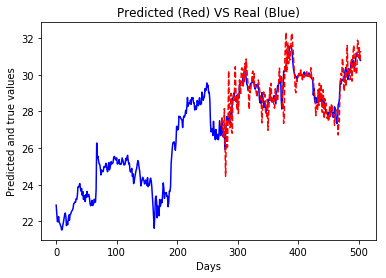

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # For each epoch, the whole training set is feeded into the tensorflow graph
    for i in range(n_epochs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_X, y_tf: train_y})
        print("Training iteration", i, "MSE", train_cost)

    # After the training, let's check the performance on the test set
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: test_X, y_tf: test_y})
    print("Test dataset:", test_cost)

    # Evaluate the results
    evaluate_ts(test_X, test_y, y_pr)

    # How does the predicted look like?
    plt.plot(range(len(stock_values)), stock_values, 'b')
    plt.plot(range(len(stock_values)-test_size, len(stock_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()

# Build a LSTM model for stock prediction

In [25]:
tf.reset_default_graph()
tf.set_random_seed(101)
np.random.seed(101)

# Settings for the dataset creation
symbol = "GE"
time_dimension = 20
train_size = 252
test_size = 252 - time_dimension

# Settings for tensorflow
#learning_rate = 0.001
optimizer = tf.train.AdagradOptimizer
#n_epochs = 100
#n_embeddings = 128


learning_rate = 0.01
n_epochs = 1000
n_embeddings = 256

# Fetch the values, and prepare the train/test split
stock_values = fetch_stock_price(symbol, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
print (len(stock_values))
minibatch_cos_X, minibatch_cos_y = format_dataset(stock_values, time_dimension)

train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

train_X_ts = train_X[:, :, np.newaxis]
test_X_ts = test_X[:, :, np.newaxis]

# Here, the tensorflow code
X_tf = tf.placeholder("float", shape=(None, time_dimension, 1), name="X")
y_tf = tf.placeholder("float", shape=(None, 1), name="y")


# Here the model: a LSTM
def RNN(x, weights, biases):
    x_ = tf.unstack(x, time_dimension, 1)
    lstm_cell = rnn.BasicLSTMCell(n_embeddings)
    #lstm_cell = rnn.GRUCell(n_embeddings)
    outputs, _ = rnn.static_rnn(lstm_cell, x_, dtype=tf.float32)
    return tf.add(biases, tf.matmul(outputs[-1], weights))


# Store layers weight & bias
weights = tf.Variable(tf.truncated_normal([n_embeddings, 1], mean=0.0, stddev=10.0), name="weights")
biases = tf.Variable(tf.zeros([1]), name="bias")


# Model, cost and optimizer
y_pred = RNN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)

loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk
504


In [23]:
#Train the LSTM regression benchmark model and evaluate using MSE and MAE metrics

Training iteration 0 MSE 2367.6968
Training iteration 100 MSE 3.8249018
Training iteration 200 MSE 0.82570344
Training iteration 300 MSE 0.36689517
Training iteration 400 MSE 0.30939308
Training iteration 500 MSE 0.24335912
Training iteration 600 MSE 0.21296714
Training iteration 700 MSE 0.19374762
Training iteration 800 MSE 0.18163717
Training iteration 900 MSE 0.17346473
Test dataset: 0.47434026
Evaluation of the predictions:
MSE: 0.47434032
mae: 0.5500248


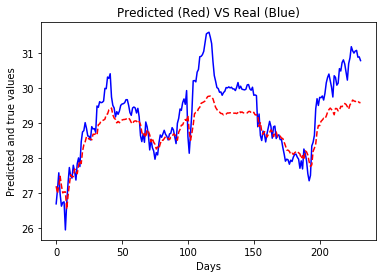

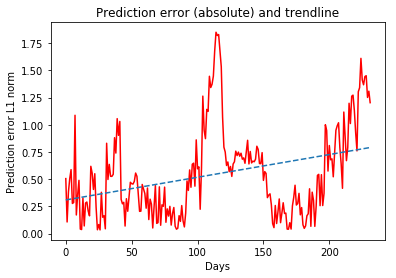

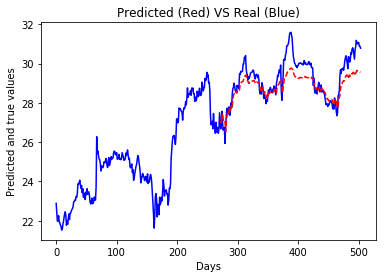

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # For each epoch, the whole training set is feeded into the tensorflow graph
    for i in range(n_epochs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_X_ts, y_tf: train_y})
        if i%100 == 0:
            print("Training iteration", i, "MSE", train_cost)

    # After the training, let's check the performance on the test set
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: test_X_ts, y_tf: test_y})
    print("Test dataset:", test_cost)

    # Evaluate the results
    evaluate_ts(test_X, test_y, y_pr)

    # How does the predicted look like?
    plt.plot(range(len(stock_values)), stock_values, 'b')
    plt.plot(range(len(stock_values)-test_size, len(stock_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()

# Tune the hyperparameters to improve the model

In [28]:
# I have tried many combinations , the following parameters gave me the best result

In [29]:

learning_rate = 0.01
n_epochs = 5000
n_embeddings = 256

In [30]:
# Train the LSTM model again with tuned parameters

Training iteration 0 MSE 2367.6968
Training iteration 100 MSE 3.8249018
Training iteration 200 MSE 0.82570344
Training iteration 300 MSE 0.36689517
Training iteration 400 MSE 0.30939308
Training iteration 500 MSE 0.24335912
Training iteration 600 MSE 0.21296714
Training iteration 700 MSE 0.19374762
Training iteration 800 MSE 0.18163717
Training iteration 900 MSE 0.17346473
Training iteration 1000 MSE 0.16760251
Training iteration 1100 MSE 0.16318169
Training iteration 1200 MSE 0.15971069
Training iteration 1300 MSE 0.1569134
Training iteration 1400 MSE 0.15460709
Training iteration 1500 MSE 0.1526313
Training iteration 1600 MSE 0.15096335
Training iteration 1700 MSE 0.14952926
Training iteration 1800 MSE 0.14827505
Training iteration 1900 MSE 0.14719374
Training iteration 2000 MSE 0.14625983
Training iteration 2100 MSE 0.14542484
Training iteration 2200 MSE 0.14469449
Training iteration 2300 MSE 0.14406686
Training iteration 2400 MSE 0.14353463
Training iteration 2500 MSE 0.14307518
Tr

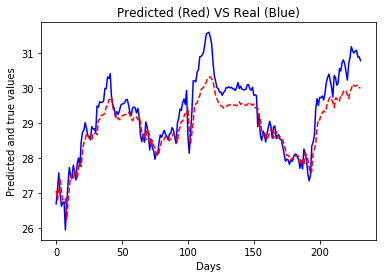

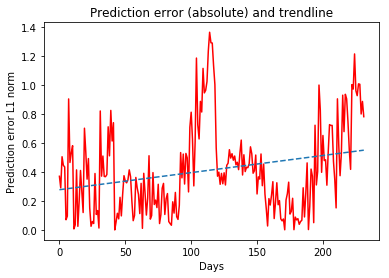

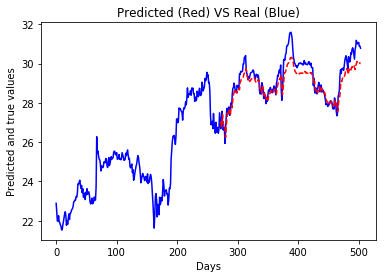

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # For each epoch, the whole training set is feeded into the tensorflow graph
    for i in range(n_epochs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_X_ts, y_tf: train_y})
        if i%100 == 0:
            print("Training iteration", i, "MSE", train_cost)

    # After the training, let's check the performance on the test set
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: test_X_ts, y_tf: test_y})
    print("Test dataset:", test_cost)

    # Evaluate the results
    evaluate_ts(test_X, test_y, y_pr)

    # How does the predicted look like?
    plt.plot(range(len(stock_values)), stock_values, 'b')
    plt.plot(range(len(stock_values)-test_size, len(stock_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()

In [ ]:
# The final LSTM model has a MSE : 0.26352108 and MAE : 0.41484645